# Metadata alterations

In this notebook, we explore the data and set the parameters for analyses downstream. 

Specifically, here we:

- Add alpha diversity values (observed_otus, chao1, shannon, faith's PD) to sample metadata
- Calculate beta distance (between time points) and dispersion (between individuals @ same time point) and add to sample metadata (bray-curtis, unweighted unifrac, weighted unifrac)
- Adjust Bd load values by fitting a poisson distribution and using point estimate as new Bd load value
- Compare the poisson prediction method of Bd load estimation to a threshold method (they are about the same in the end; poisson is less conservative)
- Add proportion and richness of inhibitory OTUs to sample metadata
- Assess non-amphibian samples and look at controls. Compare richness of "controls" to other samples
- Create NMDS coordinates for BC, UWU, and WU beta metrics; add these to sample metadata
- Plot sampling design to visualize data
- Filter metadata to only include relevant info; save this, filtered OTU tables, and filtered DM 


In [5]:
#### Load packages ####
library(tidyverse) # for data manipulation
library(MASS) # For fitting distributions and NMDS
library(gridExtra) # For arranging ggplots
library(mgcv) # For beta distribution (beta diversity)
library(vegan) # for permanova
library(car) # for type III Anova
library(RColorBrewer) # colors for barplots
library(grid) # for text grobs in gridExtra


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──
✔ ggplot2 3.2.1          ✔ purrr   0.3.3     
✔ tibble  2.1.3          ✔ dplyr   0.8.3     
✔ tidyr   1.0.0.9000     ✔ stringr 1.4.0     
✔ readr   1.3.1          ✔ forcats 0.4.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘MASS’

The following object is masked from ‘package:dplyr’:

    select


Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine

Loading required package: nlme

Attaching package: ‘nlme’

The following object is masked from ‘package:dplyr’:

    collapse

This is mgcv 1.8-31. For overview type 'help("mgcv-package")'.
Loading required package: permute
Loading required package: lattice
This is vegan 2.5-6
Loading required package: carData

Attaching package: ‘car’

The following object is masked from ‘package

In [6]:
#### Pathways ####

# OTU table in text format; rarefied to 'rared' OTUs
oturarePWD <- "0_QIITA_files/downstream/featureTable_r10k_wtaxa_filtered.txt"
# FULL Mapping file
mfPWD <- "0_QIITA_files/downstream/mapping_5sp_fixed.txt"
# Alpha diversity files
alpha_metrics <- "2_diversity_outputs/alpha_metrics.txt"
alphaPD_metrics <- "2_diversity_outputs/alphaPD_metrics.txt"
# Beta diversity files
beta_metrics <- "2_diversity_outputs/beta_metrics.txt"
betaPD_metrics <- "2_diversity_outputs/betaPD_metrics.txt"

# Inhibitory metadata; columns must be "host","inhib status","isolate number","OTU ID", "fulldescrp","OTU taxonomy"
inhibPWD <- "./1_woodhams_antifungal/mapping_inhib_otus_final.txt"

In [7]:
#### LOAD DATA ####

# Load mappingfile 
mf <- read.delim(paste0(mfPWD), header=TRUE, as.is=TRUE, row.names=1)
mf$SampleID <- rownames(mf)
# Load full OTU table
otu <- read.delim(paste0(oturarePWD), header=TRUE, as.is=TRUE, skip=1)
colnames(otu) <- gsub("X","",colnames(otu))
colnames(otu)[1] <- "OTU.ID"
# Load alpha and beta diversity files
# Load alpha and beta diversity files
alpha <- read.delim(paste0(alpha_metrics), header=FALSE)
alphaPD <- read.delim(paste0(alphaPD_metrics), header=FALSE)
allAlpha <- rbind(alpha,alphaPD)

beta <- read.delim(paste0(beta_metrics), header=FALSE)
betaPD <- read.delim(paste0(betaPD_metrics), header=FALSE)
allBeta <- rbind(beta,betaPD)

for ( a in allAlpha$V1) {
    assign(a, read.delim(paste0("2_diversity_outputs/exported_",a,"/alpha-diversity.tsv")))
}

for ( b in allBeta$V1) {
    assign(b, read.delim(paste0("2_diversity_outputs/exported_",b,"/distance-matrix.tsv"), header=TRUE, row.names=1))
}


# Load inhibitory data
inhib <- read.delim(paste0(inhibPWD), header=TRUE, as.is=TRUE)

## Alpha diversity metrics

In [8]:
# Alter column names
for ( a in allAlpha$V1) {
    temp <- get(a)
    colnames(temp)[1] <- "SampleID"
    assign(paste0(a), temp)
}

for ( b in allBeta$V1) {
    temp <- get(b)
    colnames(temp) <- rownames(get(b))
    assign(paste0(b), temp)
}


In [9]:
# Filter MF to match OTU table
mf_filt <- mf[which(mf$SampleID %in% colnames(otu)),]

# Create a "spec" column
mf_filt <- mf_filt %>%
    separate(indiv_id, into=c("spec","i"), remove=FALSE)

mf_alt <- mf_filt
for ( a in allAlpha$V1) {
    mf_alt <- mf_alt %>%
    left_join(get(a), by="SampleID")
}


Warning message:
“Column `SampleID` joining character vector and factor, coercing into character vector”Warning message:
“Column `SampleID` joining character vector and factor, coercing into character vector”Warning message:
“Column `SampleID` joining character vector and factor, coercing into character vector”Warning message:
“Column `SampleID` joining character vector and factor, coercing into character vector”

## Beta diversity metrics

We need to add two beta diversity metrics to the metadata:\
First, we want to add DISPERSION (how far away each individual is from the group centroid)\
Second, we want to add DISTANCE (how far away each individual is from its previous time point)


This is done before I filter out contaminated individuals.

### Adding distance

In [10]:
for ( beta in as.vector(allBeta$V1) ) {
    mf_alt[,paste0("dist_",beta)] <- NA
    current_dm <- get(beta)
    for ( samp in 1:nrow(mf_alt)) {
        currentSample <- mf_alt$SampleID[samp]
        current <- mf_alt[samp, c("indiv_id","time_point_ranked")]
        prevSample <- mf_alt$SampleID[mf_alt$indiv_id==as.character(current[1,1]) & mf_alt$time_point_ranked == as.numeric(current[1,2]-1)]
        
        if (length(prevSample) == 1 & length(currentSample) == 1 ) {
           if (  (currentSample %in% rownames(current_dm)) & (prevSample %in% rownames(current_dm))) {
                distTemp <- current_dm[currentSample,as.character(prevSample)]
                if ( length(distTemp) > 0) {
                    mf_alt[samp,paste0("dist_",beta)] <- distTemp
                }
            } 
        }
        
    }
}



### Adding  dispersion
Another aspect of beta diversity that might change between species and individuals is the dispersion of an individual relative to all other individuals. That is, how much different is an individual from the centroid of all samples at that time point of that species?

In [11]:
# Get dispersion of each species at each timepoint
for ( beta in as.vector(allBeta$V1) ) {
    disper <- vector()
    current_dm <- get(beta)
    for ( sp in levels(factor(mf_alt$spec))) {
        current.samps <- mf_alt %>%
                    filter(spec==sp) %>%
                    dplyr::select(SampleID) %>%
                    pull()
        current.dm <- current_dm[current.samps, current.samps]
        current.mf <- mf_alt %>%
                    filter(SampleID %in% current.samps)
                # Make same order, just inc ase
        current.mf <- current.mf[match(colnames(current.dm),current.mf$SampleID),]
                # There might be a warning that we are missing certain samples-- this is fine.
        disp.temp <- betadisper(dist(current.dm), group = (current.mf$time_point_ranked), type = "centroid")
        disper <- c(disper, disp.temp$distances)
    }
    
    # add to mf.rare and mf.raw
    mf_alt[,paste0("disper_",beta)] <- data.frame(disper)[match(mf_alt$SampleID, rownames(data.frame(disper))),]
    
}


## Adjusting Bd load values

One of the problems with the BD qPCR results is that we get very irregular results. Thus, each individual measurement is unreliable. Here, I use a parameterized model to predict the "true" Bd load given the measurements taken. I would expect BD load to be modelled by an approximately poisson process; here, we check if this is true.
\
\
A poisson distribution models a process where there is an expected "distance" or "time" between events, and you want to model how many events occur in a certain "distance" or "timespan". In the Bd system, an approximately equal amount of Bd is applied to each individual, and we measure the intensity of Bd through qPCR of a Bd-specific amplicon. One of the assumptions of the poisson distribution is that events are independent, and that the probability for an event over short intervals is the same as over long intervals. The Bd intensity is bound by zero, and has a hypothetical upper limit since after a certain infeciton intensity, amphibians will die. Lambda (the rate at which an event occurs) can be thought of as the number of Bd amplicons per "unit" area. In our methods, we assume that we swab all individuals equally. Thus, the "area swabbed" is the same across all individual amphibians. The Bd load is thus essentially a measurement of how many "events" there are in an unknown but constant swabbing area. While samples of the sample individual over time violate one of the assumptions of the Poisson distribution, we are simply using all the samples to see (roughly) whether a poisson distribution is a good fit for the Bd intensity. We then use multiple qPCR results from ONE sample to estimate the "true" intensity of Bd on an individual sample. The poisson model is therefore not really modelling Bd infection, per say, but rather the accuracy of the qPCR process. 


We filtered BD two ways. First, we fit a poisson distribution to BD loads, and tested to see if expected value was significantly larger than zero. Then, we also checks all numbers to see if less than indivTHRESH. If less than indivTHRESH, it is changed to '0'. Then, it see is if at least 2 are NOT zero and the third is more than 50. If the third is less than 50 AND the other two measurements are zero, they are all changed to zeros./

For the most part, we will see that these two methods yield similar results.


Warning message:
“Calling `as_tibble()` on a vector is discouraged, because the behavior is likely to change in the future. Use `tibble::enframe(name = NULL)` instead.
This warning is displayed once per session.”

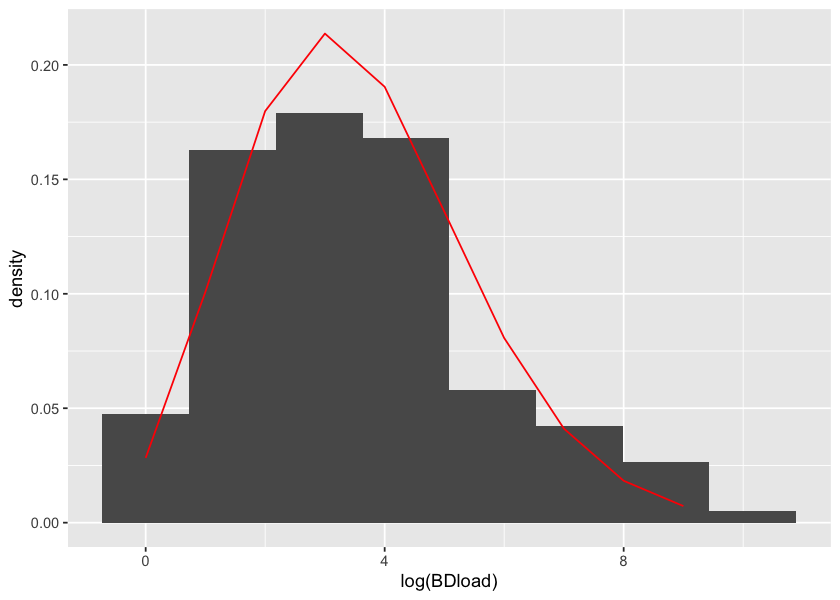

In [12]:
# Filter out all information except BD-positive scenarios
BD <- mf_alt %>%
    as_tibble() %>%
    dplyr::select(SampleID, bd_run_1,bd_run_2, bd_average_run_3) %>%
    filter(!is.na(bd_average_run_3), !is.na(bd_run_1), !is.na(bd_run_2))
samples_bd <- BD$SampleID
BD <- BD %>%
    dplyr::select(-SampleID)
BD12 <- (c(BD$bd_run_1, BD$bd_run_2, BD$bd_average_run_3))
BD_df <- data.frame(BD12)

# Get rid of zeros due to overinflation in poisson model
BD12 <- BD12[BD12!=0]
# Fit a poisson model to log BD
poisfit <- MASS::fitdistr(round(log(BD12)), densfun = "Poisson")
# Set new range of X's to test
xfit <- seq(0,(max(log(BD12))))
# Predict y
pred.y <- data.frame(y.pred=dpois(x=xfit, poisfit$estimate), xfit=xfit)
# Plot histogram with poisson distribution fit
options(repr.plot.width=7, repr.plot.height=5)
BD12 %>%
    as_tibble() %>%
    rename(BDload=value)%>%
    ggplot(aes(x=log(BDload))) +
    geom_histogram(aes(y=..density..), bins=8) +
    geom_line(data=pred.y,aes(x=xfit, y=y.pred), col="red")


What we see above is that BD load (when not zero) is, in fact, modelled well by a poisson process. This means we could fit a poisson model to the aPCR results to estimate the "true" infection load (lambda) for each toad.

In [13]:
# Model true infection load for each toad

BD_lambda_est <- t(apply(round(log(BD+1)), MARGIN=1, FUN=function(x) {
    temp <- fitdistr(x, densfun="Poisson")
    return(c(lambda=temp$estimate,sd=temp$sd))
})) %>%
    as_tibble() %>%
    rename(sd=sd.lambda, lambda=lambda.lambda) %>% 
    mutate(pval=dnorm(0,mean=lambda,sd=sd)) %>% # To estimate if lambda is significantly different from zero, we see if pval for parameter estimate different from zero
    mutate(sig=pval<=0.10)
final_BD <- cbind(BD,BD_lambda_est)

# To compare, let's see what a different filtering method yields:
# If 2 BD samples are 0 and the third is less than 50, then set to zero.
# Also, if anything is less than 5, make it zero anyway.

# BD filtering notes and thresholds:
indivTHRESH = 5 # BD individual threshold
thirdTHRESH = 50 # BD 3rd sample threshold
BD_alt <- BD
for ( r in 1:nrow(BD_alt) ) {
    for ( c in 1:ncol(BD_alt) ) {
        if ( (BD_alt[r,c] < indivTHRESH) | is.na(BD_alt[r,c]) ) {
            BD_alt[r,c] <- 0
        }
    }
    if ( (sum(BD_alt[r,] == 0) == 2) & (max(BD_alt[r,],na.rm=TRUE) < thirdTHRESH) ) {
        BD_alt[r,] <- c(0,0,0)
    }
    
}
BD_alt$infected <- rowSums(BD_alt) >0

cbind(final_BD[,c("bd_run_1","bd_run_2","bd_average_run_3","pval","sig")], alt_infect =BD_alt$infected)



bd_run_1,bd_run_2,bd_average_run_3,pval,sig,alt_infect
<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>
2.05,1.22,16.83,4.393495e-02,TRUE,FALSE
235.50,216.50,320.80,1.003727e-04,TRUE,TRUE
0.00,10.52,16.83,4.393495e-02,TRUE,TRUE
71.90,5.64,23.67,4.431848e-03,TRUE,TRUE
18.78,28.72,7.90,7.750120e-03,TRUE,TRUE
0.00,83.41,53.73,7.750120e-03,TRUE,TRUE
0.00,6.41,13.65,4.393495e-02,TRUE,TRUE
1975.00,2037.00,3254.00,1.501039e-06,TRUE,TRUE
8324.00,6060.00,13977.33,1.880743e-07,TRUE,TRUE


What we see is that by using a significant threshold of p=0.1 (which is fairly relaxed), the poisson model method is less stringent than the straight threshold method. I believe the poisson model method is likely more reliable since it is able to detect cases where infection is truely low, but consistent. For example, there are some cases where all 3/3 samples were BD-positive but at low abundances; however, the straight threshold model does not recognize it as a 'positive' since the abundances are below the individual threshold. I believe the poisson model method uses more of the information in the qPCR methods than the straight threshold method.\
From here, we will add in the "expected" BD load (lambda) into the mapping file for each toad.


In [14]:
# Insert expected BD loads for each sample
final_BD <- cbind(samples_bd, final_BD)
mf_alt$eBD <- 0
mf_alt[match(final_BD$samples_bd, mf_alt$SampleID),"eBD"] <- final_BD$lambda

# Lastly, make a PABD column
mf_alt <- mf_alt %>%
mutate(PABD=ifelse(eBD>0, 1, 0))

## Adding inhibitory data

In [15]:
# Make OTU PA
otu_pa <- otu
rownames(otu_pa) <- otu_pa$OTU.ID
otu_pa <- otu_pa[,-c(1,ncol(otu_pa))]
otu_pa[otu_pa>0] <- 1

# Make OTU non-PA
otu_temp <- otu
rownames(otu_temp) <- otu_temp$OTU.ID
otu_temp <- otu_temp[,-c(1,ncol(otu_temp))]
total <- colSums(otu_temp) # total SHOULD be 10000, the rarefaction depth.

# Match inhib data to OTU table
seq_to_match <- inhib[which(inhib$Sequence %in% rownames(otu_pa)),]
otu_pa_inhibOnly <- otu_pa[match(seq_to_match$Sequence,rownames(otu_pa)),]
otu_temp_inhibOnly <- otu_temp[match(seq_to_match$Sequence,rownames(otu_temp)),]

# Richness of inhibitory OTUs
inhibRich <- colSums(otu_pa_inhibOnly)

# Proportion of inhibitory OTUs
percInhib <- colSums(otu_temp_inhibOnly)/total

# Now, add to metadata

 mf_alt <- mf_alt %>%
left_join(data.frame(inhibRich, SampleID=names(inhibRich)), by="SampleID") %>%
left_join(data.frame(percInhib, SampleID=names(percInhib)), by="SampleID")

Warning message:
“Column `SampleID` joining character vector and factor, coercing into character vector”Warning message:
“Column `SampleID` joining character vector and factor, coercing into character vector”

## Assessment and removal of control and environmental swabs

In [16]:
# First, let's list all non-amphibians swabs
mf_alt %>%
filter(!(spec %in% c("Anbo","Rhma","Osse","Raca","Rapi"))) %>%
dplyr::select(SampleID)



SampleID
<chr>
1788.mck633Post.7Control.Mold1
1788.mck807Post.10Control.Mold
1788.mck740Post.9Control.Cricket
1788.mck743Post.9Control.Mold
1788.mck805Post.10Control.Holtfreter
1788.mck634Post.7Conrol.Mold2
1788.mck415Post.3NA
1788.mck577Post.6Control.Crickets
1788.mck806Post.10Control.Crickets


1788.mck805Post.10Control.Holtfreter 1788.mck741Post.9Control.SterileWater 
                                   23                                    26

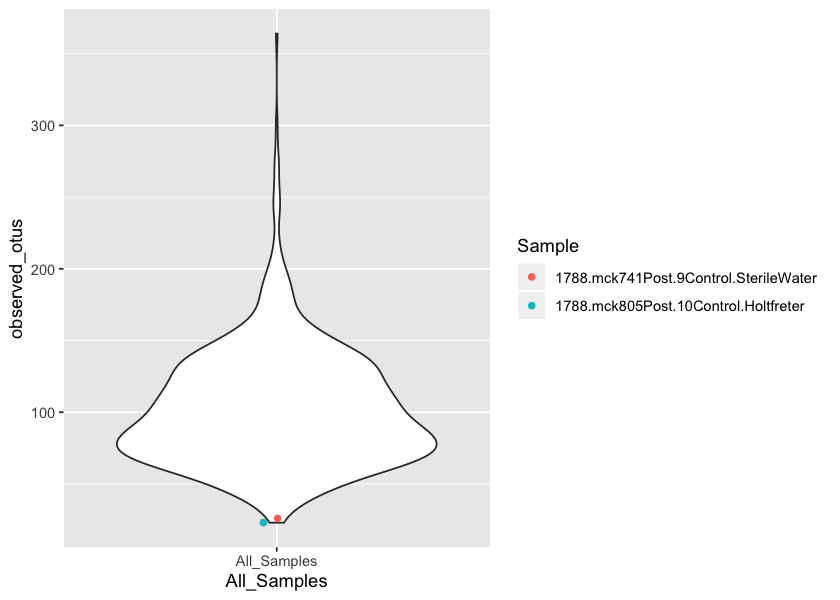

In [17]:
# There are only 2 "controls"-- the sterile water and sterile holtfreter's solution. Let's look at how many OTUs are in theset wo
con_id <- mf_alt %>%
filter(env_biome %in% c("water","media")) %>%
dplyr::select(SampleID) %>%
pull()

# total OTU counts
colSums(otu_pa[,con_id])

options(repr.plot.height=5, repr.plot.width=7)
mf_alt %>%
mutate(All_Samples="All_Samples") %>%
ggplot() +
geom_violin(aes(x=All_Samples, y=observed_otus)) +
geom_point(data=data.frame(position=colSums(otu_pa[,con_id]), Sample=names(colSums(otu_pa[,con_id])), All_Samples="All_Samples")
          , aes(x=All_Samples, y=position, col=Sample), position=position_jitter(width=0.1, height=0))



In [18]:
# Get names of sequences
otu_pa %>%
mutate(otuid=rownames(otu_pa)) %>%
dplyr::select(otuid, con_id[1], con_id[2]) %>%
filter(get(con_id[1])>0 | get(con_id[2])>0)%>%
mutate(otuid=otu[match(otuid, otu$OTU.ID),ncol(otu)])


otuid,1788.mck805Post.10Control.Holtfreter,1788.mck741Post.9Control.SterileWater
<chr>,<dbl>,<dbl>
k__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__Rhizobiales; f__Rhizobiaceae,0,1
k__Bacteria; p__Firmicutes; c__Bacilli; o__Bacillales; f__Alicyclobacillaceae; g__Alicyclobacillus; s__,1,1
k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Xanthomonadales; f__Xanthomonadaceae; g__Stenotrophomonas; s__acidaminiphila,1,0
k__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__Sphingomonadales; f__Sphingomonadaceae; g__Sphingomonas,1,0
k__Bacteria; p__Actinobacteria; c__Actinobacteria; o__Actinomycetales; f__Microbacteriaceae; g__Microbacterium,0,1
k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Pseudomonadales; f__Moraxellaceae; g__Acinetobacter; s__,0,1
k__Bacteria; p__Actinobacteria; c__Actinobacteria; o__Actinomycetales; f__Corynebacteriaceae; g__Corynebacterium,0,1
k__Bacteria; p__Bacteroidetes; c__[Saprospirae]; o__[Saprospirales]; f__Chitinophagaceae; g__; s__,0,1
k__Bacteria; p__Actinobacteria; c__Actinobacteria; o__Actinomycetales; f__Microbacteriaceae; g__Microbacterium,1,0


What we see is that there are less OTUs in the controls than the samples (good!) but that the two controls are also very different in composition. This probably means the contamination is due to cross-well contamination (which would introduce different contaminants to each control), as opposed to plate-wide contamination, in which you would expect similar contaminant OTUs in two controls. \

Next, we will remove all these "controls" from the dataset.

In [19]:
mf_nocon <- mf_alt %>%
filter(spec %in% c("Anbo","Rhma","Osse","Raca","Rapi"))

## Removing contaminated individuals

In [20]:
# were there any controls that had Bd, and if so, what was the earliest time point they had it?
con_contam <- mf_nocon %>%
    filter(PABD==TRUE, exposed_to_bd100kzsp_3122011=='n') %>%
    dplyr::select(indiv_id, time_point_ranked) %>%
    group_by(indiv_id) %>%
    summarise(firstinfect=min(time_point_ranked))

# get all time points after that
toDel <- c()
for ( n in 1:length(con_contam$indiv_id)) {
    toad <- con_contam$indiv_id[n]
    minTime <- con_contam$firstinfect[n]
    temp <- mf_nocon %>%
        filter(indiv_id==toad, time_point_ranked>=minTime) %>%
        dplyr::select(SampleID) %>%
        pull()
    toDel <- c(toDel, temp)
}
# Get rid of post-infected ones that weren't supposed to be infected
# Note: this also inadvertently filters out all controls swabs, etc.
mf_alt_filt <- mf_nocon %>%
    filter(bd_contam_upon_arrival == 0, !(SampleID %in% toDel))



## Adding NMDS plot 
### For whole dataset, AND just filtered samples

In [21]:
# All samples, including controls
set.seed(898345)
for ( b in allBeta$V1) {
    # All samples
    assign(paste0("all_nmds_",b), isoMDS(d=as.dist(get(b)), k=2))
    # Filter to include only samples
    assign(paste0(b,"_filt"), get(b)[mf_alt_filt$SampleID,mf_alt_filt$SampleID])
    # Filtered NMDS
    assign(paste0("nocon_nmds_",b), isoMDS(d=as.dist(get(paste0(b,"_filt"))), k=2))

}
#all_nmds_bc <- isoMDS(d=as.dist(braycurtis), k=2)
#all_nmds_uwu <- isoMDS(d=as.dist(unweighted_unifrac), k=2)

# Filter to include only samples
#braycurtis_filt <- braycurtis[mf_alt_filt$SampleID,mf_alt_filt$SampleID]
#unweighted_unifrac_filt <- unweighted_unifrac[mf_alt_filt$SampleID,mf_alt_filt$SampleID]

#nocon_nmds_bc <- isoMDS(d=as.dist(braycurtis_filt), k=2)
#nocon_nmds_uwu <- isoMDS(d=as.dist(unweighted_unifrac_filt), k=2)


initial  value 41.575774 
iter   5 value 29.270814
iter  10 value 28.275477
iter  10 value 28.249488
iter  10 value 28.243577
final  value 28.243577 
converged
initial  value 39.700812 
iter   5 value 29.359102
iter  10 value 28.156873
final  value 28.098784 
converged
initial  value 38.912255 
iter   5 value 26.859244
iter  10 value 22.565397
final  value 22.460103 
converged
initial  value 36.645862 
iter   5 value 23.333153
final  value 22.816493 
converged
initial  value 28.035991 
iter   5 value 18.989303
final  value 18.612558 
converged
initial  value 26.238439 
iter   5 value 18.830412
iter  10 value 18.501236
iter  10 value 18.491855
iter  10 value 18.491209
final  value 18.491209 
converged


In [22]:
# Add the NMDS points to each mapping file
for ( b in allBeta$V1) {
    mf_alt[,c(paste0("NMDS1_",b), paste0("NMDS2_",b))] <- get(paste0("all_nmds_",b))$points[mf_alt$SampleID,]
    mf_alt[,c(paste0("NMDS_stress_",b))] <- get(paste0("all_nmds_",b))$stress
    
    mf_alt_filt[,c(paste0("NMDS1_",b), paste0("NMDS2_",b))] <- get(paste0("nocon_nmds_",b))$points[mf_alt_filt$SampleID,]
    mf_alt_filt[,c(paste0("NMDS_stress_",b))] <- get(paste0("nocon_nmds_",b))$stress

}

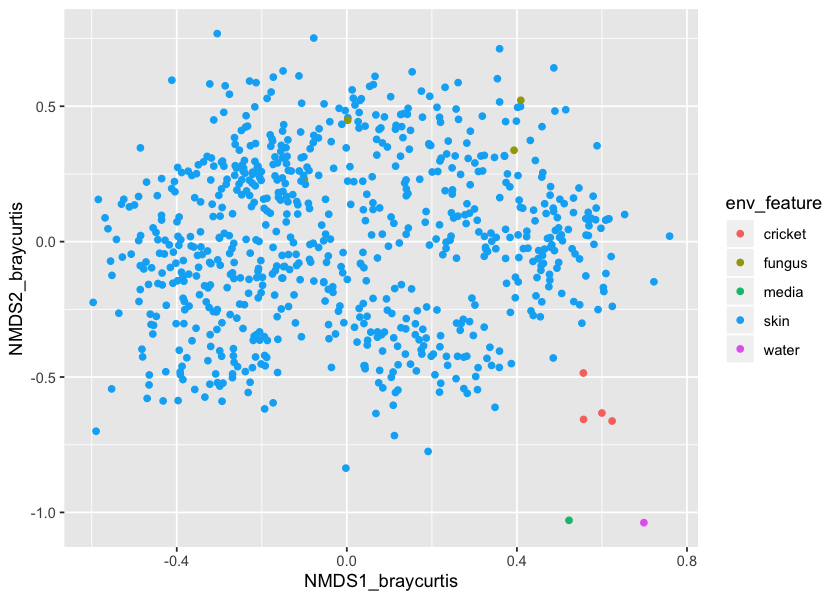

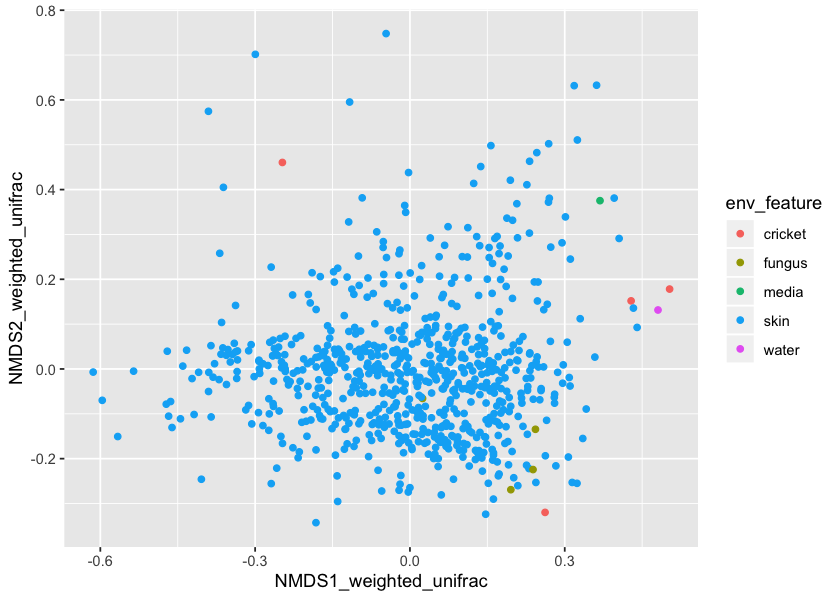

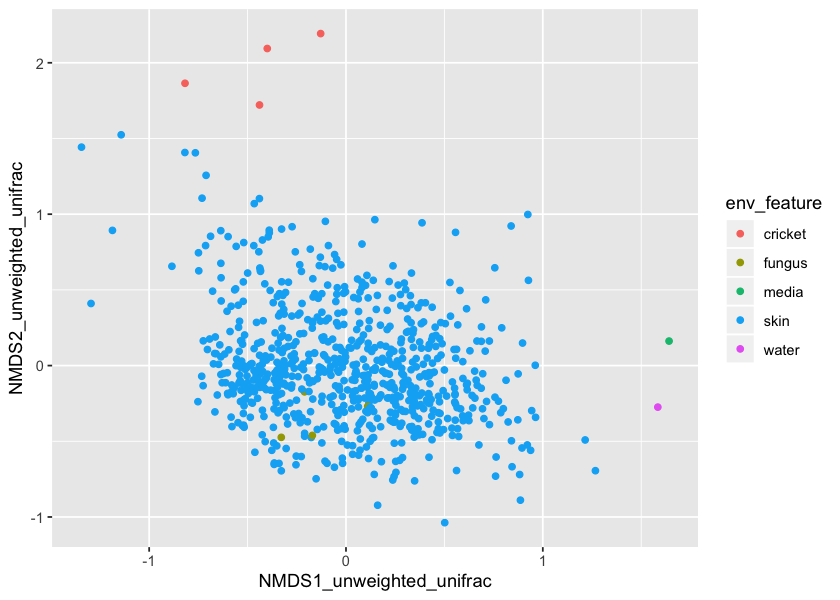

In [23]:
options(repr.plot.height=5, repr.plot.width=7)

mf_alt %>%
    ggplot() +
    geom_point(aes(x=NMDS1_braycurtis, y=NMDS2_braycurtis, col=env_feature))
mf_alt %>%
    ggplot() +
    geom_point(aes(x=NMDS1_weighted_unifrac, y=NMDS2_weighted_unifrac, col=env_feature))
mf_alt %>%
    ggplot() +
    geom_point(aes(x=NMDS1_unweighted_unifrac, y=NMDS2_unweighted_unifrac, col=env_feature))

## Final adjustments to mapping file

Finally, we will filter the metadata for each mapping file so it contains only what we need for downstream analyses. We also rename some columns.

In [24]:
#### Edit metadata/mapping file #####
toKeepMF <-  c("SampleID"
               ,"eBD" # infection levels
               , "PABD" # presence/absence bd load
               ,"spec" # Species code
               ,"indiv" # individual number
               ,"prepost_exposure" # whether it was pre or post; should rename
               ,"exposed_to_bd100kzsp_3122011" # whether or not individual was exposed to BD: will rename
               ,"indiv_id" # individual frog ID
               , "time_point_ranked" # timepoint
               , "bd_contam_upon_arrival"
               , as.character(allAlpha$V1)
               , paste0("dist_",allBeta$V1)
               , paste0("disper_", allBeta$V1)
               , "inhibRich"
               , "percInhib"
               , paste0(rep(c("NMDS1_", "NMDS2_","NMDS_stress_"), each=3), rep(allBeta$V1, 3))
               
)

newNames <- c("SampleID"
              , "Bd_load"
              , "PABD"
              , "species"
              , "indiv"
              , "prepost"
              , "Bd_exposure"
              , "indivID"
              , "time"
              , "orig_contam"
              , as.character(allAlpha$V1)
               , paste0("dist_",allBeta$V1)
               , paste0("disper_", allBeta$V1)
               , "inhibRich"
               , "percInhib"
               , paste0(rep(c("NMDS1_", "NMDS2_","NMDS_stress_"), each=3), rep(allBeta$V1, 3))
)

mf_alt_final <- mf_alt %>% # mapping file with controls still in it
    as_tibble() %>% # make into tibble
    dplyr::select(one_of(toKeepMF)) %>% # filter to only relevant variables
    rename_at(vars(toKeepMF), ~ newNames) %>%
    mutate(prepost=factor(prepost, levels=c("Pre","Post"))
          , indiv=factor(indiv, levels=c("1","2","3","4","5","6","7","8","9","10","11","12"))
          , Bd_exposure= ifelse(Bd_exposure=='y','Bd-exposed','Control')) %>%
    mutate(Bd_exposure=factor(Bd_exposure, levels=c('Bd-exposed','Control')))
mf_alt_filt_final <- mf_alt_filt %>% # mapping file without controls
    as_tibble() %>% # make into tibble
    dplyr::select(one_of(toKeepMF)) %>% # filter to only relevant variables
    rename_at(vars(toKeepMF), ~ newNames) %>% #rename variable names
    mutate(Bd_exposure= ifelse(Bd_exposure=='y','Bd-exposed','Control')) %>%
    mutate(species=factor(species, levels=c("Anbo","Rhma","Osse","Raca","Rapi"))
          , prepost=factor(prepost, levels=c("Pre","Post"))
          , indiv=factor(indiv, levels=c("1","2","3","4","5","6","7","8","9","10","11","12"))) %>%
    mutate(Bd_exposure=factor(Bd_exposure, levels=c('Bd-exposed','Control')))



Plot preliminary experimental design, just to make sure everything is working fine

Warning message:
“Removed 515 rows containing missing values (geom_point).”

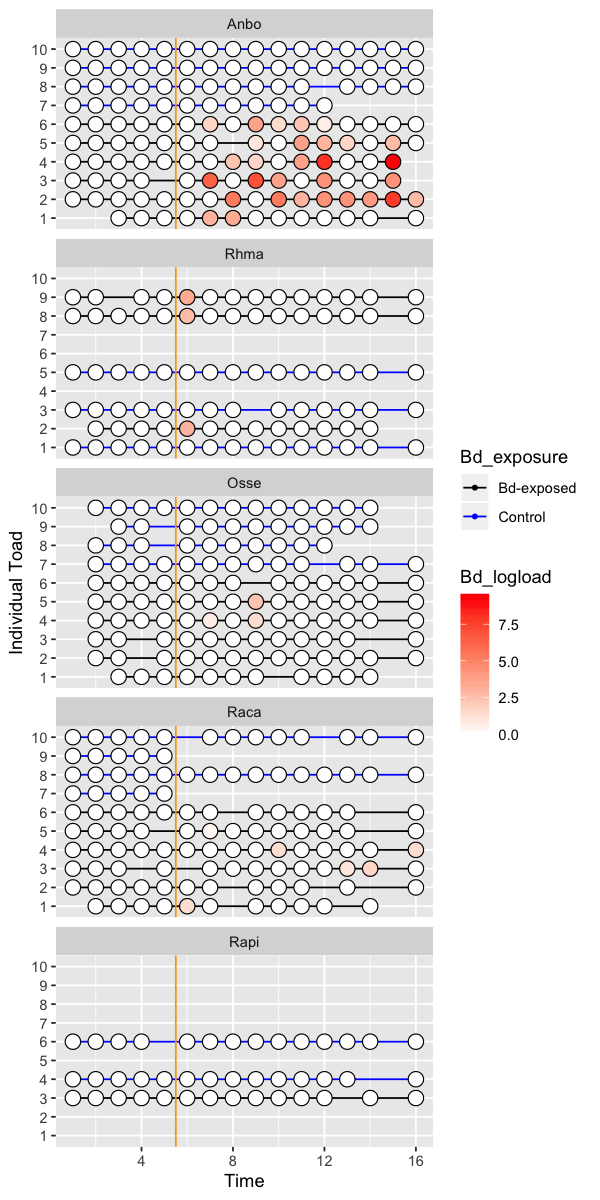

In [25]:
options(repr.plot.width=5, repr.plot.height=10)
mf_alt_filt_final %>%
    filter(species %in% c("Anbo","Rhma","Osse","Raca","Rapi")) %>%
    mutate("Bd_logload" = (Bd_load)) %>%
    mutate(Contaminated = factor(ifelse(orig_contam ==1, "!Contaminated",NA), levels=c("!Contaminated"))) %>%
    ggplot(aes(x=time, y=indiv)) +
    geom_line(aes(group=indivID, col=Bd_exposure)) +
    geom_point(aes(group=indivID,bg=Bd_logload), cex=4, pch=21)+
    scale_color_manual(values=c("black","blue","orange")) +
    scale_fill_gradient(low = "white", high = "red") +
    geom_vline(aes(xintercept=5.5), col="orange")+
    geom_point(aes(group=indivID, col=Contaminated), cex=1, pch=19)+ ## NEW LINE
    facet_wrap(~species, nrow=5) +
    xlab("Time") +
    ylab("Individual Toad")


## Save new mapping files and OTU tables to be used in downstream analyses


In [26]:
dir.create("3_5sp_mapping_otu_downstream")

# Save as RData
save(mf_alt_filt_final, file="./3_5sp_mapping_otu_downstream/mf_alt_filt_final.RData")
save(mf_alt_final, file="./3_5sp_mapping_otu_downstream/mf_alt_final.RData")

# Save as a file
write.table(mf_alt_filt_final, file="./3_5sp_mapping_otu_downstream/mf_5sp_onlyAmph.txt"
            , row.names = FALSE, col.names=TRUE
           , quote=FALSE
           , sep="\t")
write.table(mf_alt_final, file="./3_5sp_mapping_otu_downstream/mf_5sp_allSamples.txt"
            , row.names = FALSE, col.names=TRUE
           , quote=FALSE
           , sep="\t")



Warning message in dir.create("3_5sp_mapping_otu_downstream"):
“'3_5sp_mapping_otu_downstream' already exists”

In [32]:
# Create OTU table with actual OTU taxonomies and inhibitory data
taxonomy <- data.frame(Sequence=otu$OTU.ID, taxonomy=otu$taxonomy)
taxonomy$inhibitory <- match(taxonomy$Sequence, inhib$Sequence)
taxonomy <- taxonomy %>%
mutate(inhibitory=ifelse(is.na(inhibitory), 0,1))

In [33]:
# Filter OTU tables and add taxonomy
otu_filt <- otu_temp %>%
dplyr::select(one_of(mf_alt_filt_final$SampleID)) %>%
#mutate(taxonomy=taxonomy[match(rownames(otu_temp),taxonomy[,1]),2]) %>%
mutate("#OTU ID"=rownames(otu_temp)) %>%
dplyr::select("#OTU ID", everything())


otu_filt_inhibOnly <- otu_temp_inhibOnly %>%
dplyr::select(one_of(mf_alt_filt_final$SampleID)) %>%
#mutate(taxonomy=taxonomy[match(rownames(otu_temp_inhibOnly),taxonomy[,1]),2]) %>%
mutate("#OTU ID"=rownames(otu_temp_inhibOnly)) %>%
dplyr::select("#OTU ID", everything())

# Save as RData
save(otu_filt, file="./3_5sp_mapping_otu_downstream/otu_filt.RData")
save(otu_filt_inhibOnly, file="./3_5sp_mapping_otu_downstream/otu_filt_inhibOnly.RData")
save(taxonomy, file="./3_5sp_mapping_otu_downstream/taxonomy.RData")


# Save as a file
write.table(otu_filt, file="./3_5sp_mapping_otu_downstream/otu_filt.txt"
            , row.names = FALSE, col.names=TRUE
           , quote=FALSE
           , sep="\t")
write.table(otu_filt_inhibOnly, file="./3_5sp_mapping_otu_downstream/otu_filt_inhibOnly.txt"
            , row.names = FALSE, col.names=TRUE
           , quote=FALSE
           , sep="\t")
write.table(taxonomy, file="./3_5sp_mapping_otu_downstream/taxonomy.txt"
            , row.names = FALSE, col.names=TRUE
           , quote=FALSE
           , sep="\t")


In [34]:
# Finally, save dm and metrics so I don't have to re-load them in the future

save(braycurtis_filt, file="./3_5sp_mapping_otu_downstream/braycurtis_filt.RData")
save(unweighted_unifrac_filt, file="./3_5sp_mapping_otu_downstream/unweighted_unifrac_filt.RData")
save(weighted_unifrac_filt, file="./3_5sp_mapping_otu_downstream/weighted_unifrac_filt.RData")

alpha_metrics <- allAlpha$V1
beta_metrics <- allBeta$V1
save(alpha_metrics, file="./3_5sp_mapping_otu_downstream/alpha_metrics.RData")
save(beta_metrics, file="./3_5sp_mapping_otu_downstream/beta_metrics.RData")